# Анализ данных для онлайн-магазина Стримчик

В работе проанализированны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы, с целью выявления закономерностей влияющих на успешность игры.

In [62]:
# Импортирую библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import seaborn as sns
from scipy import stats as st

## Изучим данные

In [63]:
data = pd.read_csv('games(2).csv')

In [64]:
data.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [65]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Общее количество строк 16715\
Пропущенные значения есть в колонках:
- Name
- Year_of_Release
- Genre
- Critic_Score
- User_Score
- Rating

Изменим названия столбцов

In [66]:
# Меняем названия столбцов
data.columns = data.columns.str.lower()

print(data.columns)

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')


**Обработаем пропуски**\
В колонках с категориальными значениями genre и rating пропущенные значения заменим на unknown

In [67]:
# Обработка пропусков
data['genre'] = data['genre'].fillna('unknown')
data['rating'] = data['rating'].fillna('unknown')

print(data.isna().sum())

name                  2
platform              0
year_of_release     269
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         6701
rating                0
dtype: int64


В колонке user_score есть значение tbd - подлежит уточнению т.е. неизвестно. Значит его можно заменить на nan. После этого можно менять тип колонки на числовой

In [68]:
# Обработка пропусков, изменение типа данных
data.loc[data['user_score'] == 'tbd', 'user_score'] = np.nan
data['user_score'] = data['user_score'].astype('float')

print(data.isna().sum())

name                  2
platform              0
year_of_release     269
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         9125
rating                0
dtype: int64


Остальные типы данных решили не изменять , так как они вполне подходят для анализа

In [69]:
# Просматриваем значения, чтобы сделать вывод о причинах пропусков
print(data.loc[data['rating'] == 'unknown']['year_of_release'].value_counts())

2010.0    456
2008.0    446
2011.0    433
2009.0    415
2007.0    376
1998.0    347
2006.0    328
2012.0    298
1999.0    296
2015.0    291
1997.0    270
1996.0    256
2014.0    236
2005.0    233
2013.0    228
2016.0    222
1995.0    219
2000.0    202
2002.0    174
2004.0    164
2003.0    162
2001.0    143
1994.0    120
1993.0     62
1981.0     46
1991.0     41
1992.0     41
1982.0     36
1986.0     21
1983.0     17
1989.0     17
1987.0     16
1990.0     16
1984.0     14
1988.0     14
1985.0     13
1980.0      9
Name: year_of_release, dtype: int64


В колонках critic_score и user_score, year_of_release не заполняем пропуски так как для этого нет корректных данных

Причины, которые могли привести к пропускам:\
- в колонке name пропусков мало и они скорее всего случайны
- в колонках critic_score и user_score пропуски могут означать невостребованность игры
- в rating пропуски появились как в старых играх, так и в более новых. Могут быть человеческим фактором

In [70]:
#Проверка наличия явных дубликатов
print('Количество явных дубликатов', data.duplicated().sum())

Количество явных дубликатов 0


In [71]:
# general_sales - суммарные продажи во всех регионах 'na_sales', 'eu_sales', 'jp_sales', 'other_sales'
data['general_sales'] = data['na_sales'] + data['eu_sales'] + data['jp_sales'] + data['other_sales']

data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,general_sales
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,unknown,40.24
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,unknown,31.38


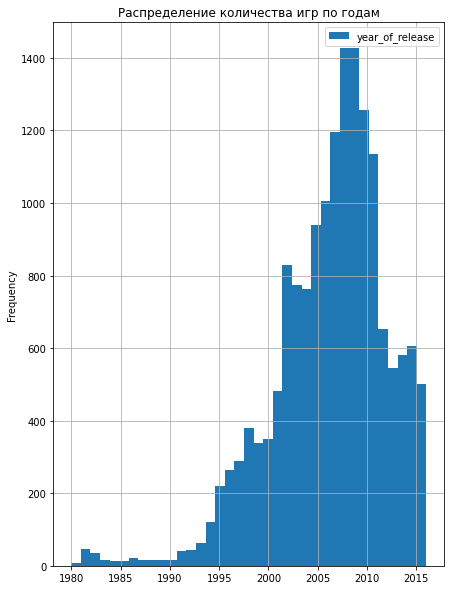

In [72]:
# Смотрим количество игр по годам
data.plot(y='year_of_release', kind = 'hist', title='Распределение количества игр по годам', bins = 37, grid = True, figsize=(7, 10));


Больше всего игр было выпущено с 2007 по 2010 года. В 2015 году виден резкий скачок.\
С 2005 по 2010 - наиболее важный период, он отображает максимальный рост после 3-х годового спада.\
Данные до 1991 года не так важны. В этот период выпускалось мало игр.

  platform  general_sales
0      PS2        1255.77
1     X360         971.42
2      PS3         939.65
3      Wii         907.51
4       DS         806.12
5       PS         730.86
6      GBA         317.85
7      PS4         314.14
8      PSP         294.05
9       PC         259.52


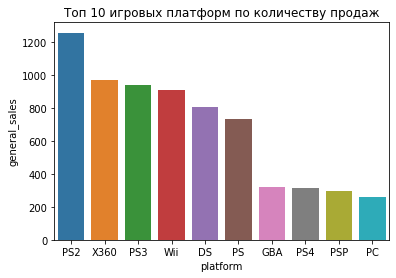

In [73]:
# изменение продаж по платформам
platform_pivot = data.pivot_table(index='platform', values='general_sales', aggfunc='sum').sort_values('general_sales', ascending=False)
best_platforms = platform_pivot.head(10).reset_index()
plot_best_platforms = sns.barplot(x=best_platforms['platform'], y=best_platforms['general_sales'])
plot_best_platforms.set_title('Топ 10 игровых платформ по количеству продаж')

print(best_platforms)

Для 6 платформ с наибольшими суммарными продажами построим графики распределения общих продаж по годам

In [74]:
best_platforms_new = best_platforms.loc[best_platforms['general_sales'] > 500.0]['platform']
name = list(best_platforms_new)
name

['PS2', 'X360', 'PS3', 'Wii', 'DS', 'PS']

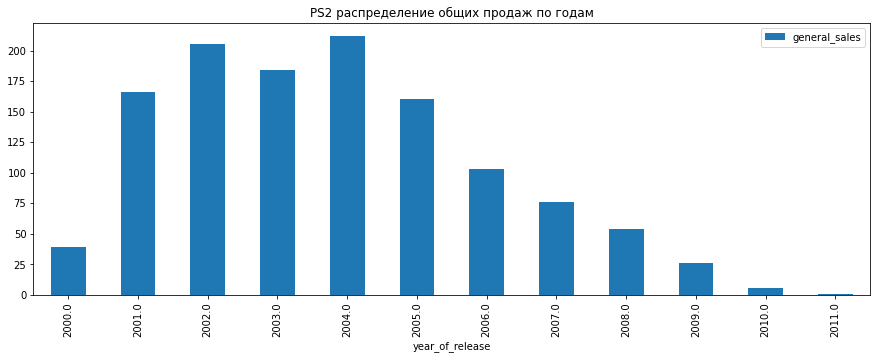

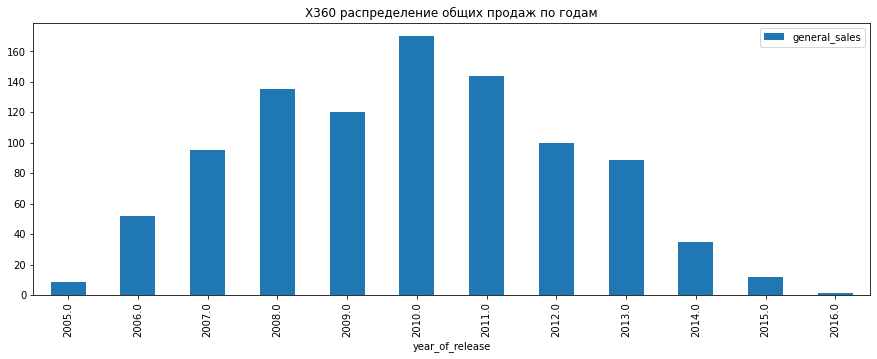

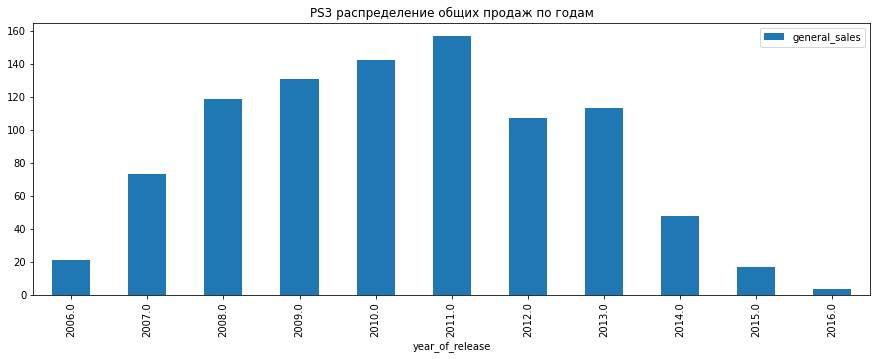

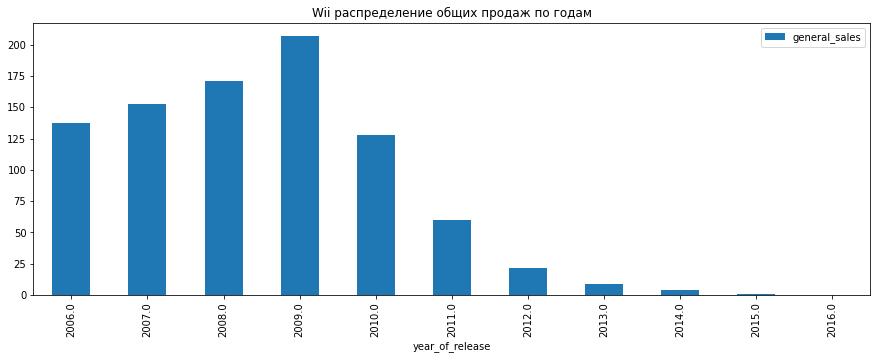

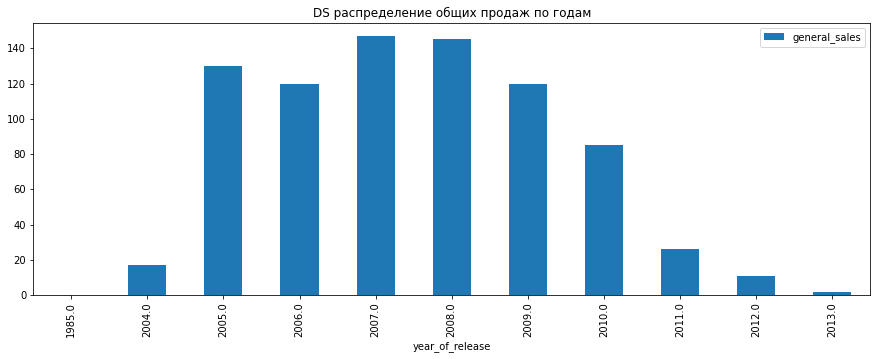

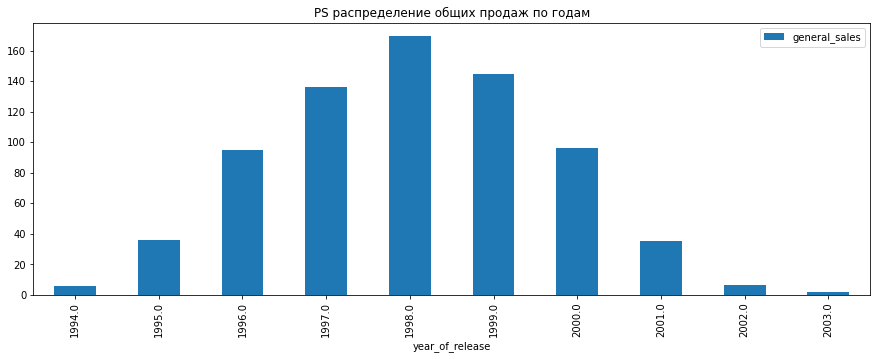

In [75]:
for i in name:
    (
        data.loc[data['platform'] == i]
        .pivot_table(index = 'year_of_release', values = 'general_sales', aggfunc = 'sum')
        .plot(kind = 'bar', title=f'{i} распределение общих продаж по годам', figsize=(15,5))
    );

В среднем самые популярные платформы проходят стадии от роста до стагнации за 10 лет. Но для дальнейшего исследования 10 лет, это довольно долгий период. Многие из представленных консолей устареют к 2017 году. Прогресс в сфере видеоигр не стоит на месте, новые консоли появляются чаще и быстрее чем предыдущие становятся устаревшими. Поэтому для дальнейшего исследования возьмём за актуальный период с 2013 года по 2016

<AxesSubplot:xlabel='year_of_release'>

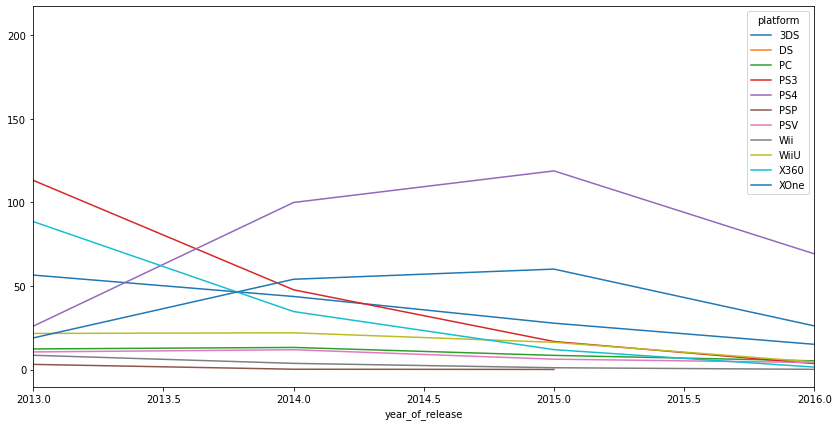

In [76]:
# смотрим изменения в количестве выходящих игр
valid_data = data.loc[data['year_of_release'] >= 2013.0]

platform_pivot_2016 = (valid_data.pivot_table(index='platform', values='general_sales', aggfunc='sum')
   .sort_values('general_sales', ascending=False)
)
(
data.query('platform in @platform_pivot_2016.index')
   .pivot_table(index='year_of_release', columns = 'platform', values='general_sales', aggfunc='sum')
   .plot(xlim=(2013.0, 2016.0),figsize=(14, 7))
)

Чтобы увидеть изменения платформ актуальных в 2016 году, мы вывели график продаж с 2013 года. Так в выборку войдёт актуальный период в 3 года\
На графике видно, что к 2016 году продажи многих платформ падают, несмотря на то, что количество выпускаемых игр в этом году сильно выросло. Но данные на 2016 год могут быть неполными.

Потенциально прибыльные платформы - PS3, X360, PS4, 3DS, XOne.

(0.0, 5.0)

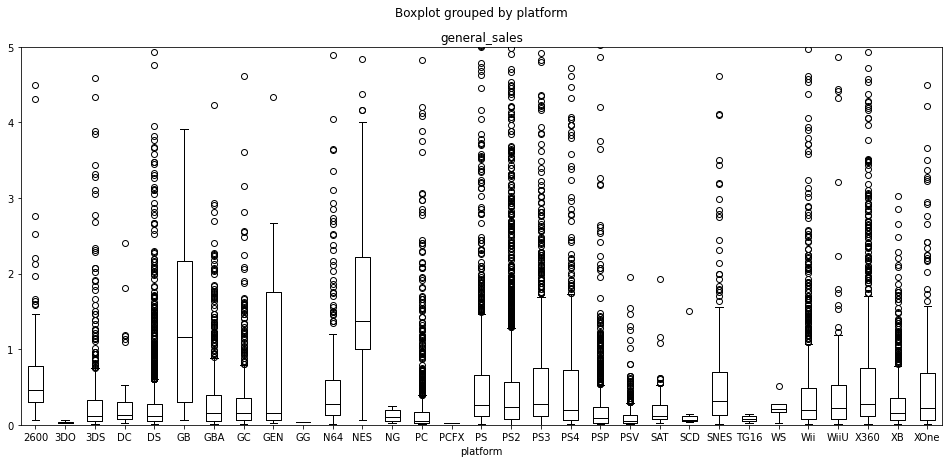

In [77]:
# Строим ящик с усами для всех платформ
data.boxplot('general_sales', by='platform', grid= False , color='black', figsize=(16, 7))
plt.ylim(0, 5)


(0.0, 2.0)

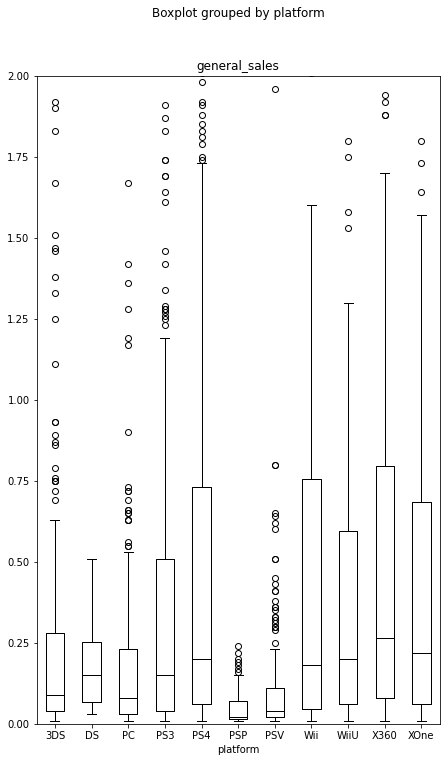

In [78]:
# Строим ящик с усами для платформ на период с 2013 по 2016 год
valid_data.boxplot('general_sales', by='platform', grid= False , color='black', figsize=(7, 12))
plt.ylim(0, 2)

К потенциально прибыльным платформам (PS3, X360, PS4, 3DS, XOne) можно добавить WiiU. Эта платформа показывает высокие продажи и медианную стоимость.

Коэффициент корреляции: 0.4065679020617816


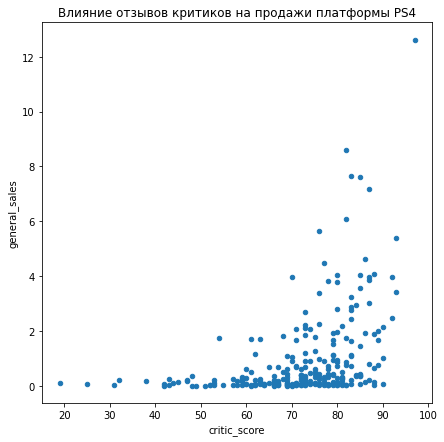

In [79]:
# оценка влияния отзывов критиков на продажи платформы PS4 на период с 2013 по 2016 год

data_PS4 = valid_data.loc[data['platform'] == 'PS4']
#print(data_PS4)
data_PS4.plot(x='critic_score', y='general_sales', kind='scatter', title='Влияние отзывов критиков на продажи платформы PS4', figsize=(7, 7))
print('Коэффициент корреляции:', data_PS4['general_sales'].corr(data_PS4['critic_score']))

Коэффициент корреляции: -0.03195711020455643


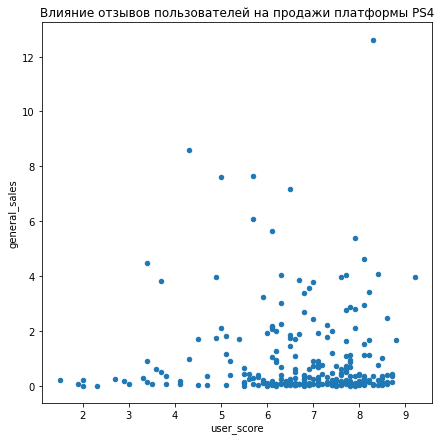

In [80]:
# оценка влияния отзывов пользователей на продажи платформы PS4 на период с 2013 по 2016 год

data_PS4.plot(x='user_score', y='general_sales', kind='scatter', title='Влияние отзывов пользователей на продажи платформы PS4', figsize=(7, 7))
print('Коэффициент корреляции:', data_PS4['general_sales'].corr(data_PS4['user_score']))

**Влияние отзывов пользователей и критиков на продажи платформу PS4**\
Оценка критиков имеет небольшое положительное влияние на продажи. Если оценки критиков высокие, то игра соберёт немного больше, если низкие, то немного меньше.\
Оценки пользователей не влияют на продажи. Это может быть связано с накруткой таких отзывов, или наоборот с преднамеренным занижением оценок самим комьюнити.

Проверим отличается ли влияние оценок пользователей и критиков на продажи всех платформ от PS4

Коэффициент корреляции оценок критиков к продажам: 0.2812510848217571


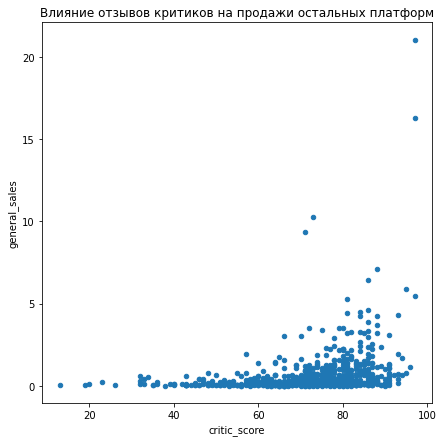

In [81]:
# Коэффициент корреляции оценок критиков и общей стоимости для остальных платформ на период с 2013 по 2016 год
# Отфильтруем данные платформы PS4

valid_data_without_PS4 = valid_data.loc[valid_data['platform'] != 'PS4']

print('Коэффициент корреляции оценок критиков к продажам:', valid_data_without_PS4['general_sales'].corr(valid_data_without_PS4['critic_score']))
valid_data_without_PS4.plot(x='critic_score', y='general_sales', kind='scatter', title='Влияние отзывов критиков на продажи остальных платформ', figsize=(7, 7));

Коэффициент корреляции оценок пользователей к продажам: -0.001121624209337856


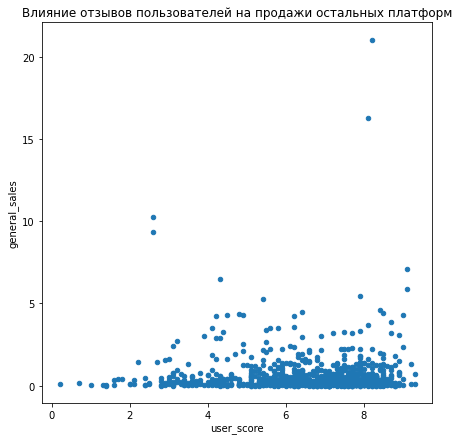

In [82]:
# Коэффициент корреляции оценок пользователей и общей стоимости для остальных платформ на период с 2013 по 2016 год
print('Коэффициент корреляции оценок пользователей к продажам:', valid_data_without_PS4['general_sales'].corr(valid_data_without_PS4['user_score']))
valid_data_without_PS4.plot(x='user_score', y='general_sales', kind='scatter', title='Влияние отзывов пользователей на продажи остальных платформ', figsize=(7, 7));

На такую платформу как PS4 оценки критиков и пользователей в среднем оказывают немного большее влияние, это может быть связано с высокой популярностью платформы.

In [83]:
# Создаём сводную таблицу по жанрам игр на период с 2013 по 2016 год (количество игр, общие сборы)
genre_pivot = (valid_data.pivot_table(index='genre', values='name', aggfunc='count')
               .sort_values('name', ascending=False).reset_index())
genre_pivot.columns = ['genre', 'count']
genre_general_sales_pivot = (valid_data.pivot_table(index='genre', values='general_sales', aggfunc='sum')
                             .sort_values('general_sales', ascending=False).reset_index())
genre_pivot = genre_pivot.merge(genre_general_sales_pivot, on='genre', how='left')
print(genre_pivot)

           genre  count  general_sales
0         Action    766         321.87
1   Role-Playing    292         145.89
2      Adventure    245          23.64
3         Sports    214         150.65
4        Shooter    187         232.98
5           Misc    155          62.82
6         Racing     85          39.89
7       Fighting     80          35.31
8       Platform     74          42.63
9     Simulation     62          21.76
10      Strategy     56          10.08
11        Puzzle     17           3.17


Text(0.5, 1.0, 'Распределение количества вышедших игр по жанрам на период с 2013 по 2016 год')

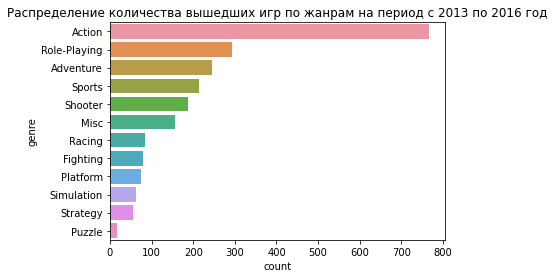

In [84]:
# Строим график распределения игр по жанрам на период с 2013 по 2016 год
plot_genre_pivot = sns.barplot(x=genre_pivot['count'], y=genre_pivot['genre'])
plot_genre_pivot.set_title('Распределение количества вышедших игр по жанрам на период с 2013 по 2016 год')

0           Action
1     Role-Playing
2        Adventure
3           Sports
4          Shooter
5             Misc
6           Racing
7         Fighting
8         Platform
9       Simulation
10        Strategy
11          Puzzle
Name: genre, dtype: object


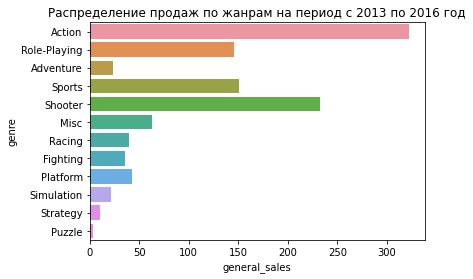

In [85]:
# Строим график распределения продаж по жанрам на период с 2013 по 2016 год
plot_genre_sales_pivot = sns.barplot(x=genre_pivot['general_sales'], y=genre_pivot['genre'])
plot_genre_sales_pivot.set_title('Распределение продаж по жанрам на период с 2013 по 2016 год')
print(genre_pivot['genre'])

Посмотрим на распределение за 2016 год

Text(0.5, 1.0, 'Распределение продаж по жанрам в 2016 году')

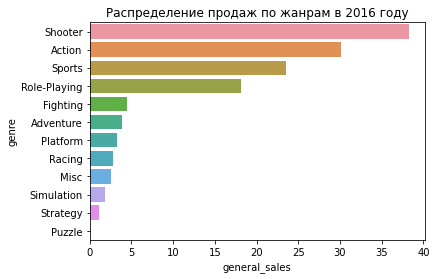

In [86]:
# Строим график распределения продаж по жанрам в 2016 году
game_2016 = data.loc[data['year_of_release'] == 2016.0]
game_2016_pivot = (game_2016.pivot_table(index='genre', values='general_sales', aggfunc='sum')
                             .sort_values('general_sales', ascending=False).reset_index())
plot_game_2016_pivot = sns.barplot(x=game_2016_pivot['general_sales'], y=game_2016_pivot['genre'])
plot_game_2016_pivot.set_title('Распределение продаж по жанрам в 2016 году')

(0.0, 4.0)

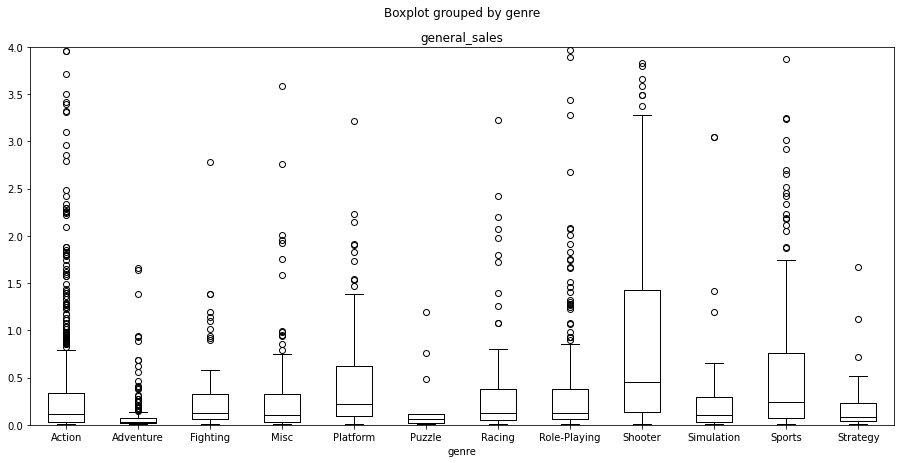

In [87]:
# Строим диаграмму размаха для игр по жанрам на период с 2013 по 2016 год
valid_data.boxplot('general_sales', by='genre', grid= False , color='black', figsize=(15, 7))
plt.ylim(0, 4)

Самым распространённым жанром игр выпущенных в 2016 году стал Action: 178. Adventure, Role-Playing, Sports, Shooter - выпустили от 47 до 56 игр.\
График средних продаж показал, что Action самый прибыльный жанр, но посмотрев на ящик с усами, видно, что на это значение сильно повлияло большое количество выбросов - очень популярных игр, высокие продажи которых исказили среднее продаж жанра.\

Рассмотрев распределение продаж по играм в 2016 году, можно сказать, что большое количество выпускаемых игр может не привести к самым высоким продажам. Игры жанра Action, приносят высокую прибыль, но если сравнить с жанром Shooter, то станет понятно, что при меньшем количестве шутеров прибыль от них больше.\
Shooter - самый прибыльный игровой жанр 2016 года. Это может быть связано с системой микротранзакций в таких играх.\
Медианный показатель продаж Shooter также самый высокий среди жанров.\
У жанров Sports и Platform медианные показатели продаж также выше чем у других.
Средние продажи Role-Playing довольно высоки из-за искажения выбросами.

**Распределение продаж в период с 2013 по 2016 году**\
Жанр Action на протяжении 3 лет лидирует по количеству игр и продаж благодаря выбросам. Жанр Shooter потенциально прибыльнее остальных.\
Platform, Sports показывают высокие медианные продажи

## Составим портрет пользователя каждого региона

In [88]:
# Функция на вход принимает название столбца с регионом
# возвращает 2 круговые диаграммы: 
# распределение продаж по платформам в этом регионе
# распределение продаж по жанрам в этом регионе
def pie_regions(name):
    platform = (valid_data.pivot_table(index='platform', values=name, aggfunc='sum')
                .sort_values(name, ascending=False))
    genre = (valid_data.pivot_table(index='genre', values=name, aggfunc='sum')
             .sort_values(name, ascending=False))
    # Строим круговую диаграмму Распределение продаж по платформам
    platform.plot(y=name, kind='pie', title=f'Распределение продаж по платформам в {name}', figsize=(8, 8))
    # Строим круговую диаграмму Распределение продаж по жанрам
    genre.plot(y=name, kind='pie', title=f'Распределение продаж по жанрам в {name}', figsize=(8, 8))

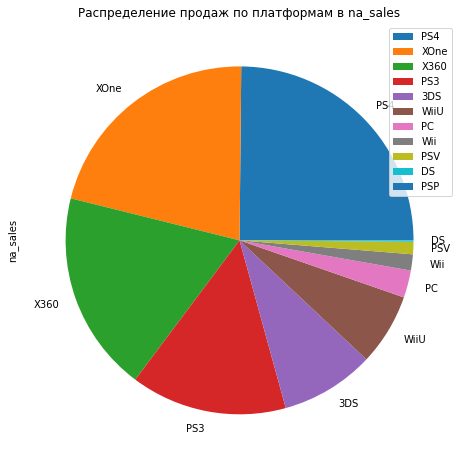

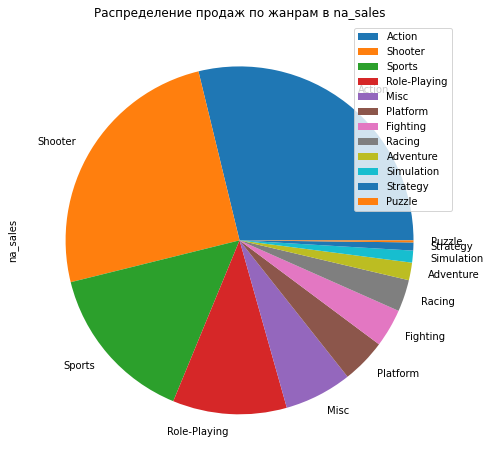

In [89]:
pie_regions('na_sales')

В регионе **NA**\
**Cамые популярные платформы:** X360, PS3, PS4\
**Самые востребованные жанры игр:** Action, Shooter, Sports

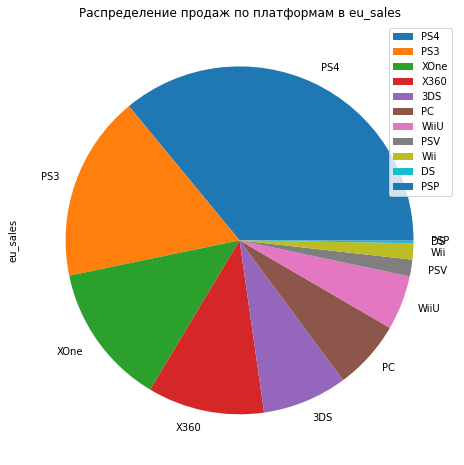

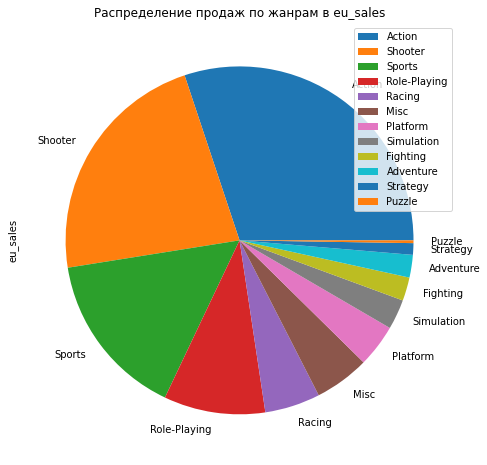

In [90]:
pie_regions('eu_sales')

В регионе **EU**\
**Cамые популярные платформы:** PS3, PS4, X360\
**Самые востребованные жанры игр:** Action, Shooter, Sports

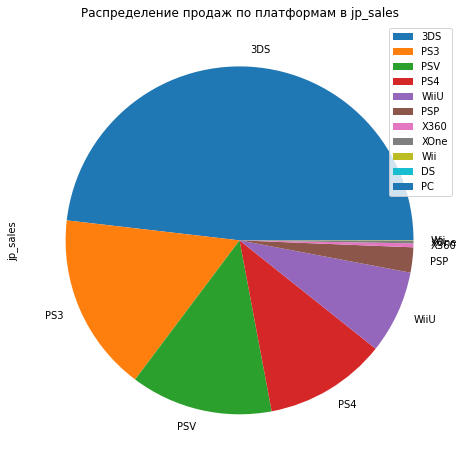

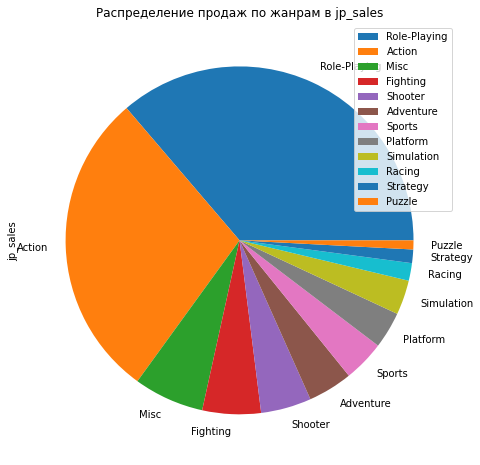

In [91]:
pie_regions('jp_sales')

В регионе **JP**\
**Cамые популярные платформы:** 3DS, PS3, PSP\
**Самые востребованные жанры игр:** Role-Playing, Action, Misc

In [92]:
# Создаём таблицу по рейтингу
rating_na = (valid_data.pivot_table(index='rating', values='na_sales', aggfunc='sum')
               .sort_values('na_sales', ascending=False).reset_index())
rating_eu = (valid_data.pivot_table(index='rating', values='eu_sales', aggfunc='sum')
               .sort_values('eu_sales', ascending=False).reset_index())
rating_jp = (valid_data.pivot_table(index='rating', values='jp_sales', aggfunc='sum')
               .sort_values('jp_sales', ascending=False).reset_index())

general_rating = rating_jp.merge(rating_eu, on='rating', how='left')
general_rating = general_rating.merge(rating_na, on='rating', how='left')
general_rating

,rating,jp_sales,eu_sales,na_sales
0,unknown,85.05,78.91,89.42
1,T,20.59,41.95,49.79
2,E,15.14,83.36,79.05
3,M,14.11,145.32,165.21
4,E10+,5.89,42.69,54.24


Влияние рейтинга на продажи в трёх регионах
- JP популярны игры без рейтинга
- EU и NA самый популярный рейтинг М 17+

**Вывод:**

В Северной Америке на первом месте по продажам игры на консоль выпускаемую в США.\
В регионе Японии все 3 фаворита выпускаются в этой стране.\
В Европе на первом месте по продажам игры на консоль произведённую в Японии.

У потребителей из Северной Америки и Европы есть сходства: в топ 3 консолей у них одинаковые фавориты, самые востребованные жанры также похожи, игры с рейтингом М пользуются большей популярностью.\
Потребители в Японии сильнее отличаются от потребителей из Европы и Северной Америки. Первое место по продажам занимает консоль 3DS, большенство игр на которую выходит без западного ESRB рейтинга. Игры без рейтинга могут быть популярны, так как они выходят с восточным аналогом от компании CERO, а такой показатель не учитывался в данных.

## Проверим гипотезы

Проверим гипотезы\
Н0: Средние пользовательские рейтинги платформ Xbox One и PC одинаковые\
Н1: Средние пользовательские рейтинги платформ Xbox One и PC разные

In [93]:
# Проверка Н0: пользовательский рейтинг платформы Xbox One == пользовательскому рейтингу платформы PC
# H1: пользовательский рейтинг платформы Xbox One != пользовательскому рейтингу платформы PC
user_score_ps = valid_data.query('platform == "PC" and not user_score.isna()')
user_score_xone = valid_data.query('platform == "XOne" and not user_score.isna()')

alpha = 0.05
results = st.ttest_ind(user_score_ps['user_score'], user_score_xone['user_score'], equal_var='False')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.14012658403611647
Не получилось отвергнуть нулевую гипотезу


Отвергнуть гипотезу Н0 не получилось. Это значит что в 62% случаев средний пользовательский рейтинг платформы Xbox One не отличается от среднего пользовательского рейтинга платформы PC

Проверим гипотезы\
Н0: Средние пользовательские рейтинги жанров Action и Sports одинаковые.\
Н1: Средние пользовательские рейтинги жанров Action и Sports разные.

In [94]:
# Проверка Н0: пользовательский рейтинг жанроа Action == пользовательскому рейтингу Sports
# Проверка Н1: пользовательский рейтинг жанроа Action != пользовательскому рейтингу Sports

user_score_action = valid_data.query('genre == "Action" and not user_score.isna()')
user_score_sports = valid_data.query('genre == "Sports" and not user_score.isna()')

alpha = 0.05
results = st.ttest_ind(user_score_action['user_score'], user_score_sports['user_score'], equal_var='False')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
     print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 1.0517832389140023e-27
Отвергаем нулевую гипотезу


В более 99% случаев пользовательский рейтинг жанра Action не совпадает с пользовательским рейтингом Sports

# Вывод

Перед началом анализа в предоставленных данных были изучены и обработаны пропуски, приведены к единому виду названия колонок.

После проведения исследовательского анализа данных с 2013 по 2016 год было выявлено, что есть критерии влияющие на успешность игы:
- Платформы остаются актуальными в период от 10 до 4 лет. Чем дальше тем короче становится актуальность платформ, так как рынок развивается всё быстрее
- Потенциально прибыльные платформы на 2017 год - PS3, X360, PS4, 3DS, XOne, WiiU
- Оценка критиков имеет небольшое положительное влияние на продажи. Если оценки критиков высокие, то игра соберёт больше, если низкие, то меньше.
- Оценки пользователей не влияют на продажи. Это может быть связано с накруткой таких отзывов, или наоборот с преднамеренным занижением оценок самим комьюнити, а также с тем, что для того чтобы оценить игру пользователю нужно сначала её купить.
- Самыми популярными жанрами игр стали Action, Shooter. Медианные продажи в шутерах на 2016 год стали самыми крупными
- Нужно учитывать предпочтения клиентов из разных регионов:
Предпочтение жителей Японии и Северной Америки в выборе платформы падают на местных производителей.\
У потребителей из Северной Америки и Европы есть сходства: самые востребованные платформы(X360, PS3, PS4), жанры (Action, Shooter, Sports), игры с рейтингом М пользуются большей популярностью.\
Потребители в Японии сильнее отличаются от потребителей из Европы и Северной Америки. Топ платформ (3DS, PS3, PSP), жанров (Role-Playing, Action, Misc). В Японии предпочитают игры без рейтинга ESRB. Это может быть связано с тем, что у предпочитаемых игр есть своя рейтинговая система.\
- Проверка гипотезы "средние пользовательские рейтинги платформ Xbox One и PC одинаковые" показала, что в 62% случаев пользовательский рейтинг платформы Xbox One совпадает с пользовательским рейтингом платформы PC
- Проверка гипотезы "Средние пользовательские рейтинги жанров Action и Sports разные" показала, что в более 99% случаев пользовательский рейтинг жанра Action не совпадает с пользовательским рейтингом Sports